This exmaple will show you how to use DeepAID Interpreter upon a SOTA NIDS *Kitsune* (NDSS'18).

We simplify the DL model to a single autoencoder for ease of illustration.

 # Prepare your DL model

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Train an autoencoder-based DL model
import numpy as np
import torch
from autoencoder import train, test, test_plot
import sys
sys.path.append('../../deepaid/')
from utils import validate_by_rmse, Normalizer
train_feat = np.load('data/train_benign_feat.npy')
normer = Normalizer(train_feat.shape[-1],online_minmax=True)
train_feat = normer.fit_transform(train_feat)
model, thres = train(train_feat, train_feat.shape[-1])
torch.save({'net':model,'thres':thres},'./save/autoencoder.pth.tar')

epoch:0/0 |Loss: 0.050325267016887665
epoch:0/10 |Loss: 0.03627059981226921
epoch:0/20 |Loss: 0.02359006181359291
epoch:0/30 |Loss: 0.017687782645225525
epoch:0/40 |Loss: 0.012251004576683044
epoch:0/50 |Loss: 0.011910964734852314
epoch:0/60 |Loss: 0.010575455613434315
epoch:0/70 |Loss: 0.010612315498292446
epoch:0/80 |Loss: 0.008414724841713905
epoch:0/90 |Loss: 0.011196578852832317
epoch:0/100 |Loss: 0.007897039875388145
epoch:0/110 |Loss: 0.00968477688729763
epoch:0/120 |Loss: 0.007968610152602196
epoch:0/130 |Loss: 0.007041106000542641
epoch:0/140 |Loss: 0.01321518886834383
epoch:0/150 |Loss: 0.007542287930846214
epoch:0/160 |Loss: 0.007705105468630791
epoch:0/170 |Loss: 0.008091779425740242
epoch:0/180 |Loss: 0.007869303226470947
epoch:0/190 |Loss: 0.008114654570817947
epoch:0/200 |Loss: 0.006699248217046261
epoch:0/210 |Loss: 0.007377055939286947
epoch:0/220 |Loss: 0.007573551964014769
epoch:0/230 |Loss: 0.0070730852894485
epoch:0/240 |Loss: 0.011596474796533585
epoch:0/250 |Loss

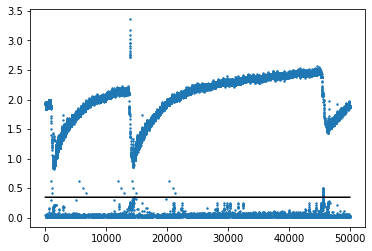

In [3]:
# Validate the performance of trained model
test_feat = np.load('data/test_mirai_ddos.npy')
test_feat = normer.transform(test_feat)
rmse_vec = test(model,thres,test_feat)
test_plot(test_feat, rmse_vec, thres) # ACC = 0.84

# Interpret your interested anomaly in four steps 

Successfully Initialize <Tabular Interptreter> for Model <autoencoder>
Finish Interpretation after 499 steps (Final loss: 0.16, Time elasped: 1.20s)

Visualize Interpretation (Table View)
+---------------------+------------------+-------+--------------------+
| Feature Description | Value in Anomaly | comp. | Value in Reference |
+---------------------+------------------+-------+--------------------+
|  MI_dir_0.1_weight  |     3227.63      |   >   |      483.413       |
|  MI_dir_0.01_weight |    23117.713     |   >   |      4259.929      |
|  MI_dir_1.0_weight  |     386.527      |   >   |      141.729       |
|  MI_dir_3.0_weight  |     170.356      |   >   |       70.842       |
|  MI_dir_5.0_weight  |      124.98      |   >   |       61.988       |
+---------------------+------------------+-------+--------------------+

Visualize Interpretation (Plot View)


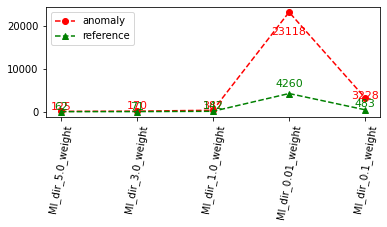


Visualize Interpretation (HeatMap View)


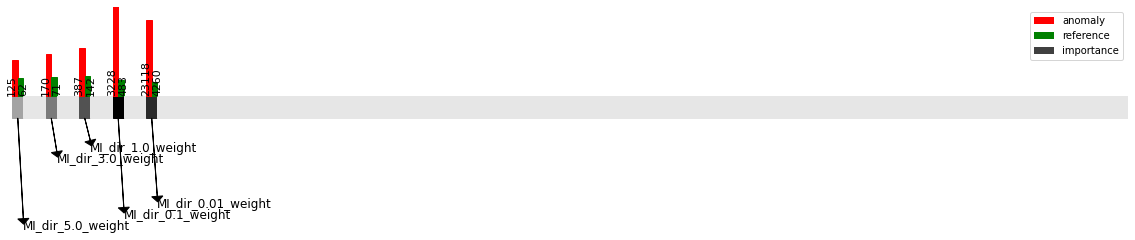

In [4]:
"""Step 1: Load your model"""
from autoencoder import autoencoder
from utils import Normalizer
model_dict = torch.load('save/autoencoder.pth.tar')
model = model_dict['net']
thres = model_dict['thres']

"""Step 2: Find an anomaly you are interested in (here we use the IP scan in Mirai botnet attack)"""
anomaly = test_feat[np.argsort(rmse_vec)[-100]]

"""Step 3: Create a DeepAID Tabular Interpreter"""
import sys
sys.path.append("../../deepaid/interpreters/")
from tabular import TabularAID
feature_desc = np.load('data/AI_feature_name.npy') # feature_description
my_interpreter = TabularAID(model,thres,input_size=100,feature_desc=feature_desc)

"""Step 4: Interpret your anomaly and show the result"""
interpretation = my_interpreter(anomaly)
# DeepAID supports three kinds of visualization of results:
my_interpreter.show_table(anomaly,interpretation, normer) 
my_interpreter.show_plot(anomaly, interpretation, normer)
my_interpreter.show_heatmap(anomaly,interpretation, normer)


**As we can see that, the top-5 influencial features from the results of Interpreter are all related to *MI_dir* (packets sent from the same MAC&IP).
This confirms the anomaly is a IP Scanning.**